In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!ls -lh /content/drive/MyDrive | grep patternmind

-rw------- 1 root root 921M Dec  2 14:03 patternmind_dataset.zip


# PatternMind — Visual Space Organization
This notebook contains **all code** for the PatternMind project. Text and code cells strictly alternate as required.

**How to use:**
1. Put your dataset on disk as folder-per-class.
2. Set `DATASET_DIR` below.
3. Run cells top-to-bottom.


In [10]:
# === CONFIG ===
from pathlib import Path

# TODO: change this to your dataset root folder (one subfolder per class)
DATASET_DIR = Path("patternmind_dataset")

# Output folder for figures required by README
OUT_DIR = Path("images")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Reproducibility
SEED = 42


## 1) Imports and reproducibility
We import libraries and set seeds for reproducible feature extraction, sampling, and clustering.

In [11]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm.auto import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler

try:
    import umap
    UMAP_AVAILABLE = True
except Exception:
    UMAP_AVAILABLE = False

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## 2) Dataset indexing
We scan the dataset directory and build a dataframe with image paths and labels. This lets us run EDA, sampling, and later analysis.

In [12]:
from glob import glob

def index_image_folder(root: Path, exts=(".jpg", ".jpeg", ".png", ".bmp", ".webp")) -> pd.DataFrame:
    rows = []
    root = Path(root)
    assert root.exists(), f"DATASET_DIR not found: {root}"
    for class_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        label = class_dir.name
        for ext in exts:
            for fp in class_dir.rglob(f"*{ext}"):
                rows.append({"path": str(fp), "label": label})
    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError("No images found. Check DATASET_DIR and file extensions.")
    return df

df = index_image_folder(DATASET_DIR)
df.head(), df["label"].nunique(), len(df)


(                                                path      label
 0  patternmind_dataset/airplanes/airplanes-101_15...  airplanes
 1  patternmind_dataset/airplanes/airplanes-101_38...  airplanes
 2  patternmind_dataset/airplanes/airplanes-101_21...  airplanes
 3  patternmind_dataset/airplanes/airplanes-101_51...  airplanes
 4  patternmind_dataset/airplanes/airplanes-101_11...  airplanes,
 233,
 25557)

## 3) EDA (Exploratory Data Analysis)
We inspect class counts and visualize a few example images per category. This checks dataset balance and potential noise.

In [13]:
# Class distribution
class_counts = df["label"].value_counts().sort_values(ascending=False)
display(class_counts.head(20))

#plt.figure()
#class_counts.plot(kind="bar")
#plt.title("Images per class")
#plt.ylabel("count")
#plt.tight_layout()
#plt.show()

counts = df["label"].value_counts()


print(f"Number of classes: {counts.shape[0]}")
print(f"Min images per class: {counts.min()}")
print(f"Max images per class: {counts.max()}")
print(f"Mean images per class: {counts.mean():.2f}")



label
clutter        761
airplanes      720
motorbikes     719
faces-easy     396
t-shirt        330
hammock        257
billiards      251
horse          246
ladder         223
bathtub        212
binoculars     195
people         193
mushroom       186
grapes         183
watch          181
leopards       175
mattress       175
soccer-ball    161
mussels        161
mars           144
Name: count, dtype: int64

Number of classes: 233
Min images per class: 72
Max images per class: 761
Mean images per class: 109.69


### Example grid per class (small sample)
We draw a simple preview grid for a subset of classes to ensure loading works and to understand intra-class variability.

/tmp/ipython-input-997140058.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(n_per_class, len(x)), random_state=SEED)))


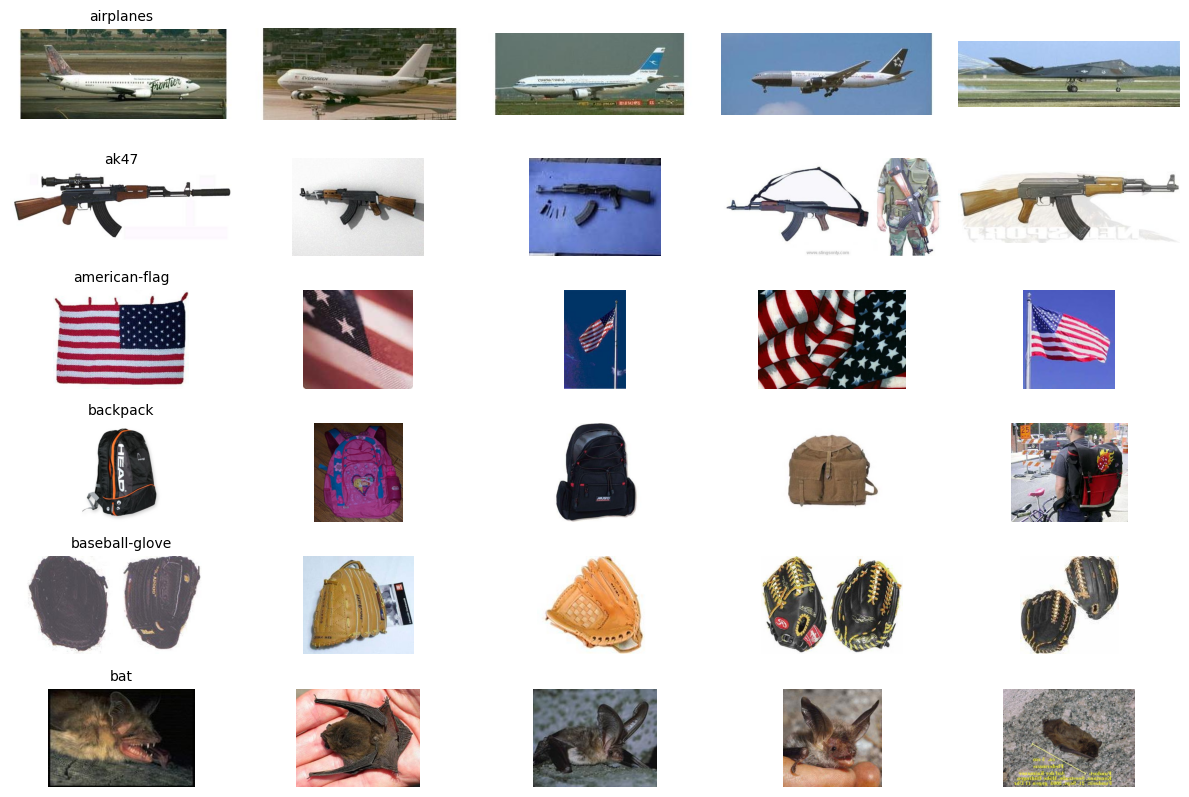

In [14]:
import math

def show_examples(df: pd.DataFrame, n_classes=6, n_per_class=6, figsize=(12, 8)):
    labels = list(df["label"].unique())[:n_classes]
    sample = (df[df["label"].isin(labels)]
              .groupby("label", group_keys=False)
              .apply(lambda x: x.sample(min(n_per_class, len(x)), random_state=SEED)))
    rows = len(labels)
    cols = n_per_class
    plt.figure(figsize=figsize)
    for i, (lbl, group) in enumerate(sample.groupby("label")):
        for j, (_, r) in enumerate(group.reset_index(drop=True).iterrows()):
            ax = plt.subplot(rows, cols, i*cols + j + 1)
            img = Image.open(r["path"]).convert("RGB")
            ax.imshow(img)
            ax.axis("off")
            if j == 0:
                ax.set_title(lbl, fontsize=10)
    plt.tight_layout()
    plt.show()

show_examples(df, n_classes=min(6, df["label"].nunique()), n_per_class=5)


## 4) Feature extraction (Deep CNN)
We use a pretrained CNN as a **fixed feature extractor**. For each image we obtain a vector representation from the penultimate layer. This representation is the basis for dimensionality reduction and clustering.

In [15]:
# Image preprocessing for pretrained models
IMG_SIZE = 224
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        label = self.df.loc[idx, "label"]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label, path

# Pretrained backbone
backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# Remove classification head => output features (2048)
backbone.fc = nn.Identity()
backbone = backbone.to(device).eval()

@torch.no_grad()
def extract_cnn_features(df: pd.DataFrame, batch_size=64, num_workers=2):
    ds = ImageDataset(df, transform=tfm)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False,
                                     num_workers=num_workers, pin_memory=True)
    feats, labels, paths = [], [], []
    for xb, yb, pb in tqdm(dl, desc="Extracting CNN features"):
        xb = xb.to(device)
        fb = backbone(xb).detach().cpu().numpy()
        feats.append(fb)
        labels.extend(list(yb))
        paths.extend(list(pb))
    X = np.vstack(feats)
    return X, np.array(labels), np.array(paths)

# Optionally subsample for speed if dataset is huge
MAX_IMAGES = 1500
if len(df) > MAX_IMAGES:
    df_run = df.sample(MAX_IMAGES, random_state=SEED).reset_index(drop=True)
else:
    df_run = df.copy()

X_cnn, y, paths = extract_cnn_features(df_run, batch_size=64, num_workers=2)
X = X_cnn
X_cnn.shape


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


Extracting CNN features:   0%|          | 0/24 [00:00<?, ?it/s]

(1500, 2048)

## 5) Baseline features (Color histograms)
As a classical baseline, we compute RGB color histograms. This often clusters by color themes (e.g., flags, sky, grass) and provides a useful contrast to CNN features.

In [16]:
def color_histogram(img: Image.Image, bins=16):
    arr = np.asarray(img.convert("RGB"))
    feat = []
    for c in range(3):
        h, _ = np.histogram(arr[:,:,c], bins=bins, range=(0,255), density=True)
        feat.append(h)
    return np.concatenate(feat).astype(np.float32)

def extract_color_hist_features(df: pd.DataFrame, bins=16):
    feats = []
    for p in tqdm(df["path"].tolist(), desc="Extracting color hist features"):
        img = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        feats.append(color_histogram(img, bins=bins))
    return np.vstack(feats)

X_col = extract_color_hist_features(df_run, bins=16)
X_col.shape


Extracting color hist features:   0%|          | 0/1500 [00:00<?, ?it/s]

(1500, 48)

## 6) Standardization
We standardize features before PCA/UMAP and clustering. This improves stability for distance-based methods.

In [17]:
scaler_cnn = StandardScaler()
Xc = scaler_cnn.fit_transform(X_cnn)

scaler_col = StandardScaler()
Xh = scaler_col.fit_transform(X_col)


## 7) Dimensionality reduction (PCA / t-SNE / UMAP)
We compute low-dimensional embeddings for visualization. We will generate and save figures for the README in the `images/` folder.

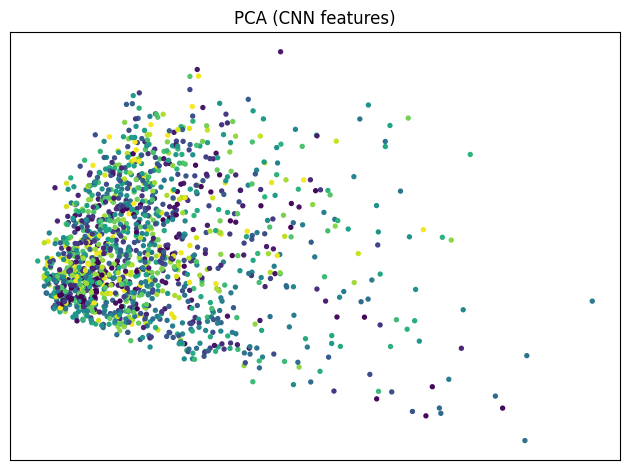

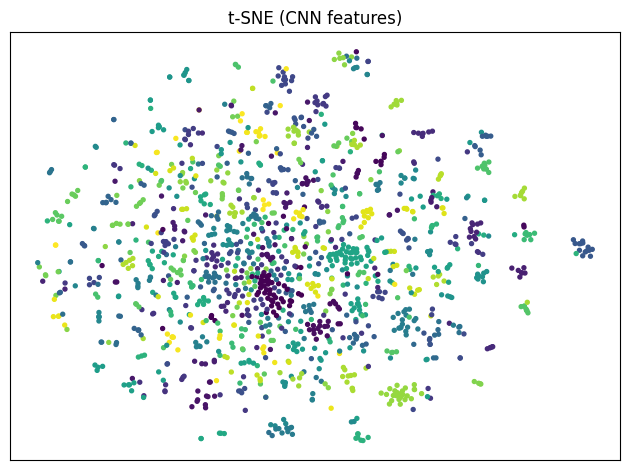

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


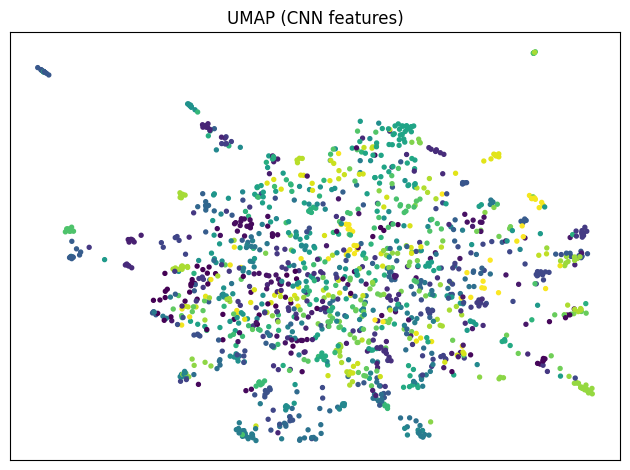

In [18]:
def embed_pca(X, n=2):
    return PCA(n_components=n, random_state=SEED).fit_transform(X)

def embed_tsne(X, n=2, perplexity=30):
    return TSNE(n_components=n, perplexity=perplexity, init="pca",
                learning_rate="auto", random_state=SEED).fit_transform(X)

def embed_umap(X, n=2, n_neighbors=15, min_dist=0.1):
    if not UMAP_AVAILABLE:
        raise ImportError("umap-learn not installed. Install it or skip UMAP.")
    return umap.UMAP(n_components=n, n_neighbors=n_neighbors, min_dist=min_dist,
                     random_state=SEED).fit_transform(X)

def plot_embedding(Z, labels, title, outpath=None, max_points=5000):
    # If many points, subsample for readability
    if len(Z) > max_points:
        idx = np.random.RandomState(SEED).choice(len(Z), size=max_points, replace=False)
        Zp = Z[idx]
        lp = labels[idx]
    else:
        Zp, lp = Z, labels

    plt.figure()
    # Map labels to integers for scatter (matplotlib handles categories poorly)
    lab_to_i = {lab:i for i, lab in enumerate(sorted(set(lp)))}
    c = np.array([lab_to_i[a] for a in lp])
    plt.scatter(Zp[:,0], Zp[:,1], c=c, s=8)
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=200)
    plt.show()

# CNN feature embeddings
Z_pca = embed_pca(Xc, 2)
plot_embedding(Z_pca, y, "PCA (CNN features)", OUT_DIR/"embedding_pca.png")

Z_tsne = embed_tsne(Xc, 2, perplexity=30)
plot_embedding(Z_tsne, y, "t-SNE (CNN features)", OUT_DIR/"embedding_tsne.png")

if UMAP_AVAILABLE:
    Z_umap = embed_umap(Xc, 2, n_neighbors=15, min_dist=0.1)
    plot_embedding(Z_umap, y, "UMAP (CNN features)", OUT_DIR/"embedding_umap.png")
else:
    Z_umap = None


## 8) Clustering
We apply several clustering algorithms to **organize** the visual space. We evaluate with internal metrics (Silhouette, Davies–Bouldin) and, for interpretation only, external agreement with labels (ARI/NMI).

In [26]:
def eval_clustering(X, cluster_ids, labels_true=None):
    # Internal metrics (no labels needed)
    uniq = set(cluster_ids)
    sil = silhouette_score(X, cluster_ids) if len(uniq) > 1 else np.nan
    dbi = davies_bouldin_score(X, cluster_ids) if len(uniq) > 1 else np.nan

    out = {"n_clusters": len(uniq), "silhouette": sil, "davies_bouldin": dbi}

    # External metrics (only if labels are provided)
    if labels_true is not None:
        out["ARI"] = adjusted_rand_score(labels_true, cluster_ids)
        out["NMI"] = normalized_mutual_info_score(labels_true, cluster_ids)

    return out


results = []

# ------------------------------------------------------------
# More realistic K values: coarse visual groupings (not classes)
# ------------------------------------------------------------
K_LIST = [10, 15, 20, 30]

for k in K_LIST:
    # KMeans
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=SEED)
    cid_km = kmeans.fit_predict(Xc)
    results.append((f"KMeans(k={k})", eval_clustering(Xc, cid_km, y)))

    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=k)
    cid_ag = agg.fit_predict(Xc)
    results.append((f"Agglomerative(k={k})", eval_clustering(Xc, cid_ag, y)))

# ------------------------------------------------------------
# DBSCAN: show that it often collapses without careful tuning
# ------------------------------------------------------------
for eps in [1.5, 2.0, 2.5, 3.0]:
    db = DBSCAN(eps=eps, min_samples=10)
    cid_db = db.fit_predict(Xc)
    results.append((f"DBSCAN(eps={eps})", eval_clustering(Xc, cid_db, y)))

pd.DataFrame([{**v, "method": m} for m, v in results]).set_index("method")



n_clusters  silhouette  davies_bouldin       ARI  \
method                                                                  
KMeans(k=10)                 10   -0.070875        4.576988  0.022353   
Agglomerative(k=10)          10   -0.019261        4.962150  0.036539   
KMeans(k=15)                 15   -0.032230        4.329621  0.030456   
Agglomerative(k=15)          15   -0.092979        4.281157  0.048318   
KMeans(k=20)                 20   -0.013812        3.874814  0.027922   
Agglomerative(k=20)          20   -0.087238        4.104590  0.053869   
KMeans(k=30)                 30   -0.060092        3.035905  0.040777   
Agglomerative(k=30)          30   -0.072187        3.868436  0.084963   
DBSCAN(eps=1.5)               1         NaN             NaN  0.000000   
DBSCAN(eps=2.0)               1         NaN             NaN  0.000000   
DBSCAN(eps=2.5)               1         NaN             NaN  0.000000   
DBSCAN(eps=3.0)               1         NaN             NaN  0.000000   

                          NMI  
method                         
KMeans(k=10)         0.360719  
Agglomerative(k=10)  0.431735  
KMeans(k=15)         0.403857  
Agglomerative(k=15)  0.496861  
KMeans(k=20)         0.430109  
Agglomerative(k=20)  0.525141  
KMeans(k=30)         0.475589  
Agglomerative(k=30)  0.598861  
DBSCAN(eps=1.5)      0.000000  
DBSCAN(eps=2.0)      0.000000  
DBSCAN(eps=2.5)      0.000000  
DBSCAN(eps=3.0)      0.000000

from matplotlib import pyplot as plt
_df_29['n_clusters'].plot(kind='hist', bins=20, title='n_clusters')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_30['silhouette'].plot(kind='hist', bins=20, title='silhouette')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_31['davies_bouldin'].plot(kind='hist', bins=20, title='davies_bouldin')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_32['ARI'].plot(kind='hist', bins=20, title='ARI')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_33.plot(kind='scatter', x='n_clusters', y='silhouette', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_34.plot(kind='scatter', x='silhouette', y='davies_bouldin', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_35.plot(kind='scatter', x='davies_bouldin', y='ARI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_36.plot(kind='scatter', x='ARI', y='NMI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_37['n_clusters'].plot(kind='line', figsize=(8, 4), title='n_clusters')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_38['silhouette'].plot(kind='line', figsize=(8, 4), title='silhouette')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_39['davies_bouldin'].plot(kind='line', figsize=(8, 4), title='davies_bouldin')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_40['ARI'].plot(kind='line', figsize=(8, 4), title='ARI')
plt.gca().spines[['top', 'right']].set_visible(False)

### Cluster visualization
We visualize cluster assignments on a 2D embedding (UMAP if available, else PCA). This is key for interpretability: compact clusters, overlaps, and outliers.

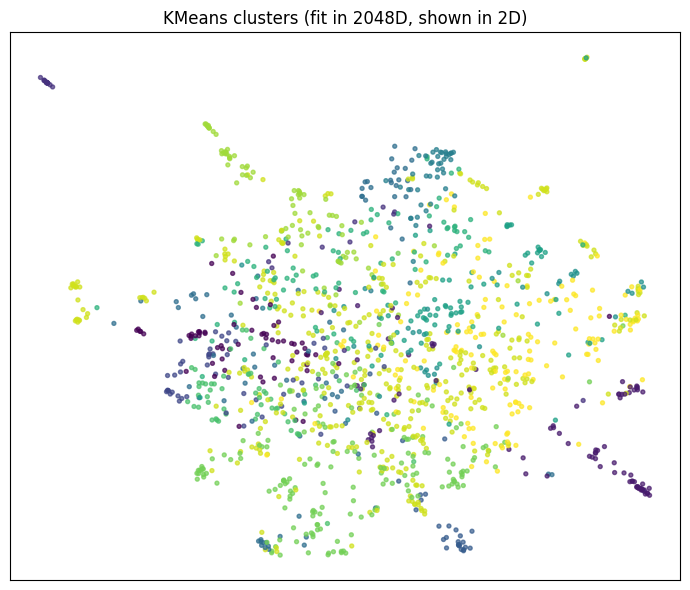

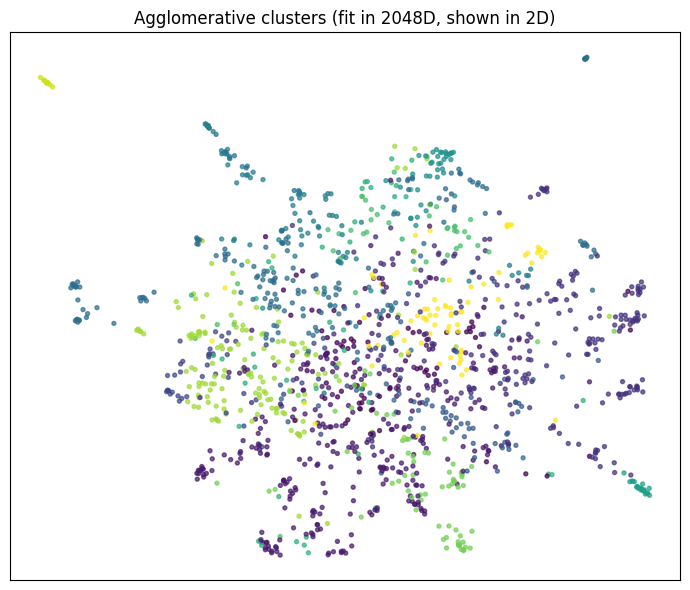

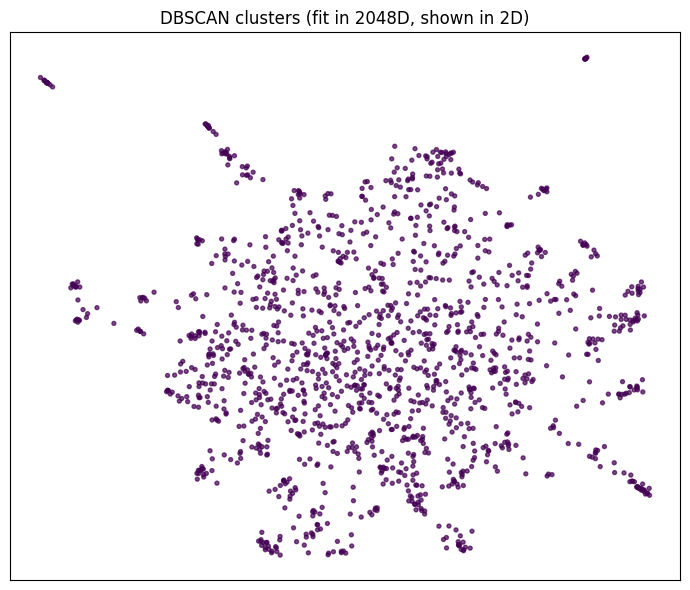

In [20]:
# ============================================================
# CLUSTERING (fit in feature space X, visualize in 2D)
# ============================================================

def plot_clusters_on_embedding(
    Z, cluster_ids, title, outpath=None, max_points=5000, alpha=0.7
):
    if len(Z) > max_points:
        idx = np.random.RandomState(SEED).choice(len(Z), size=max_points, replace=False)
        Zp = Z[idx]
        cp = np.array(cluster_ids)[idx]
    else:
        Zp = Z
        cp = np.array(cluster_ids)

    plt.figure(figsize=(7, 6))
    plt.scatter(Zp[:, 0], Zp[:, 1], c=cp, s=8, alpha=alpha)
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=200)
    plt.show()


# ------------------------------------------------------------
# Choose visualization embedding (ONLY for plotting)
# ------------------------------------------------------------
Z_vis = Z_umap if Z_umap is not None else Z_pca


# ------------------------------------------------------------
# KMEANS (on 2048D features)
# ------------------------------------------------------------
k = 15  # intentionally small: visual archetypes, not classes
kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
cid_km = kmeans.fit_predict(X)


# ------------------------------------------------------------
# AGGLOMERATIVE (on 2048D features)
# ------------------------------------------------------------
agg = AgglomerativeClustering(n_clusters=k)
cid_ag = agg.fit_predict(X)


# ------------------------------------------------------------
# DBSCAN (on 2048D features)
# ------------------------------------------------------------
db = DBSCAN(eps=3.0, min_samples=10)
cid_db = db.fit_predict(X)


# ------------------------------------------------------------
# VISUALIZE CLUSTERS (computed in X, shown in Z)
# ------------------------------------------------------------
plot_clusters_on_embedding(
    Z_vis,
    cid_km,
    "KMeans clusters (fit in 2048D, shown in 2D)",
    OUT_DIR / "clusters_kmeans.png"
)

plot_clusters_on_embedding(
    Z_vis,
    cid_ag,
    "Agglomerative clusters (fit in 2048D, shown in 2D)",
    OUT_DIR / "clusters_agglomerative.png"
)

plot_clusters_on_embedding(
    Z_vis,
    cid_db,
    "DBSCAN clusters (fit in 2048D, shown in 2D)",
    OUT_DIR / "clusters_dbscan.png"
)



## 9) Cluster–Label relationship (ambiguity / purity)
Although labels are not used to train the clustering, they help **interpret** results. We compute a cluster×label table to find:
- clusters mixing multiple labels (ambiguity)
- labels split across many clusters (high intra-class variability)


In [21]:
def cluster_label_table(cluster_ids, labels):
    tab = pd.crosstab(pd.Series(cluster_ids, name="cluster"),
                      pd.Series(labels, name="label"))
    return tab

tab_km = cluster_label_table(cid_km, y)
tab_km.head()


label    airplanes  ak47  american-flag  backpack  baseball-glove  bat  \
cluster                                                                  
0                0     0              0         0               0    0   
1                0     0              0         5               4    0   
2                0     0              0         0               0    0   
3               41     0              0         0               0    0   
4                0     0              0         0               0    0   

label    bathtub  bear  billiards  binoculars  ...  waterfall  watermelon  \
cluster                                        ...                          
0              0     0          1           0  ...          2           0   
1              2     0          0           0  ...          0           0   
2              0     0          0           0  ...          0           0   
3              0     0          0           0  ...          0           0   
4              0     0          0           0  ...          0           0   

label    welding-mask  wheelbarrow  windmill  wine-bottle  xylophone  \
cluster                                                                
0                   0            2         1            0          1   
1                   0            0         0            0          0   
2                   0            0         0            0          0   
3                   0            0         0            0          0   
4                   0            0         0            0          0   

label    yarmulke  yo-yo  zebra  
cluster                          
0               0      0      0  
1               0      0      0  
2               0      0      0  
3               0      0      0  
4               0      0      0  

[5 rows x 230 columns]

### Heatmap-like visualization (simple)
We save a figure that communicates which labels dominate each cluster.

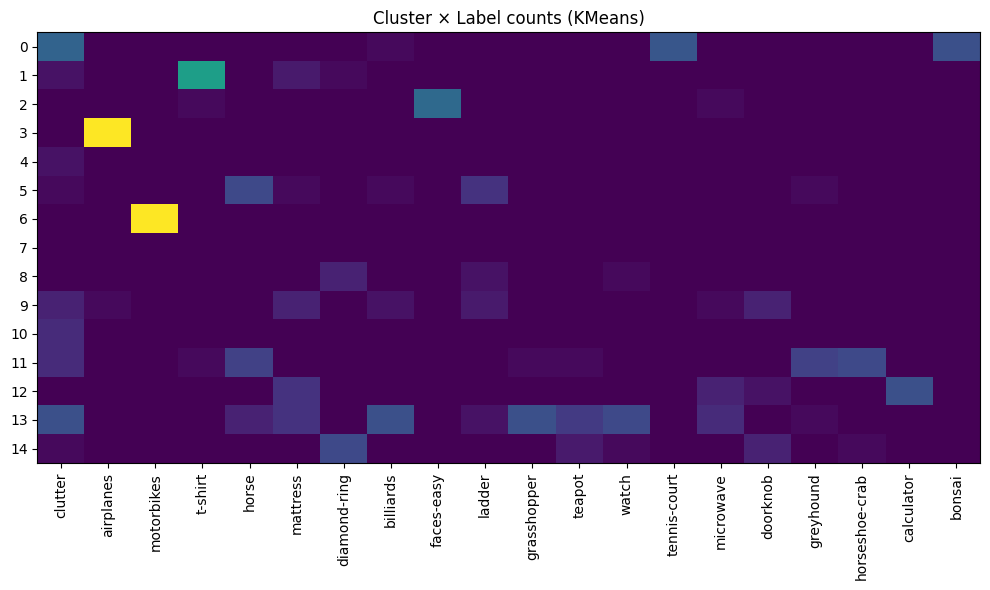

In [22]:
def save_table_heatmap_like(tab: pd.DataFrame, title: str, outpath: Path, top_labels=20):
    # Optionally reduce columns for readability
    if tab.shape[1] > top_labels:
        cols = tab.sum(axis=0).sort_values(ascending=False).head(top_labels).index
        tab = tab[cols]
    plt.figure(figsize=(10, 6))
    plt.imshow(tab.values, aspect="auto")
    plt.title(title)
    plt.yticks(range(tab.shape[0]), tab.index)
    plt.xticks(range(tab.shape[1]), tab.columns, rotation=90)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()

save_table_heatmap_like(tab_km, "Cluster × Label counts (KMeans)", OUT_DIR/"cluster_label_heatmap.png")


## 10) Nearest-neighbor analysis (semantic relationships)
To uncover relationships and ambiguities, we compute nearest neighbors in feature space. We then inspect cases where nearest neighbors belong to **different labels**, indicating visual similarity across categories.

Images: 1500
Classes: 230
Min / Mean / Max images per class: 1 / 6.52 / 43


count
label              
clutter          43
airplanes        42
motorbikes       41
t-shirt          25
horse            21
mattress         20
faces-easy       14
billiards        14
diamond-ring     14
ladder           13
microwave        11
teapot           11
tennis-court     11
watch            11
grasshopper      11

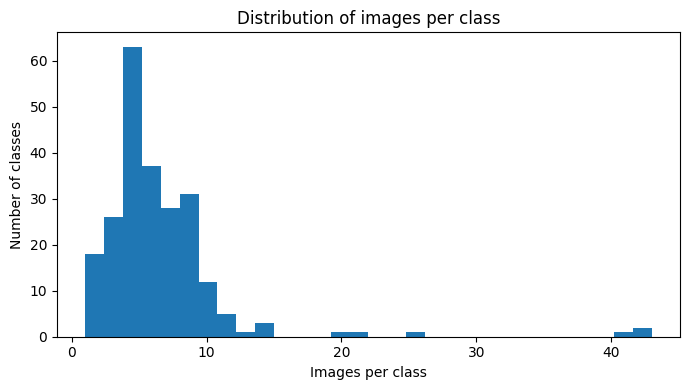


KMeans purity:
  clusters: 30
  mean purity: 0.513
  median purity: 0.450


purity
cluster          
1        1.000000
8        1.000000
11       1.000000
28       1.000000
27       1.000000
14       1.000000
29       1.000000
26       1.000000
21       0.909091
3        0.875000


Agglomerative purity:
  clusters: 30
  mean purity: 0.370
  median purity: 0.234


purity
cluster          
29       1.000000
19       1.000000
27       1.000000
28       0.872340
10       0.666667
25       0.600000
15       0.600000
17       0.600000
2        0.585714
22       0.500000


DBSCAN purity:
  clusters: 1
  mean purity: 0.029
  median purity: 0.029


purity
cluster          
-1       0.028667


Nearest-neighbor cross-label rate (k=5): 0.606

Closest cross-label neighbor pairs (top 10):


label_i        label_j   distance  same_label  \
3050    fighter-jet      airplanes  18.237677       False   
5310      airplanes    fighter-jet  18.237677       False   
2045          yo-yo      golf-ball  21.078957       False   
4300      golf-ball          yo-yo  21.078957       False   
5236  mountain-bike   touring-bike  22.956924       False   
5150   touring-bike  mountain-bike  22.956924       False   
5311      airplanes    fighter-jet  23.303686       False   
1137    fighter-jet      airplanes  23.303686       False   
7182          blimp      airplanes  23.611876       False   
4392          blimp      airplanes  23.751879       False   

                                                 path_i  \
3050  patternmind_dataset/fighter-jet/fighter-jet_41...   
5310  patternmind_dataset/airplanes/airplanes-101_23...   
2045             patternmind_dataset/yo-yo/yo-yo_52.jpg   
4300     patternmind_dataset/golf-ball/golf-ball_76.jpg   
5236  patternmind_dataset/mountain-bike/mountain-bik...   
5150  patternmind_dataset/touring-bike/touring-bike_...   
5311  patternmind_dataset/airplanes/airplanes-101_23...   
1137  patternmind_dataset/fighter-jet/fighter-jet_13...   
7182             patternmind_dataset/blimp/blimp_07.jpg   
4392             patternmind_dataset/blimp/blimp_39.jpg   

                                                 path_j  
3050  patternmind_dataset/airplanes/airplanes-101_23...  
5310  patternmind_dataset/fighter-jet/fighter-jet_41...  
2045     patternmind_dataset/golf-ball/golf-ball_76.jpg  
4300             patternmind_dataset/yo-yo/yo-yo_52.jpg  
5236  patternmind_dataset/touring-bike/touring-bike_...  
5150  patternmind_dataset/mountain-bike/mountain-bik...  
5311  patternmind_dataset/fighter-jet/fighter-jet_13...  
1137  patternmind_dataset/airplanes/airplanes-101_23...  
7182  patternmind_dataset/airplanes/airplanes-101_29...  
4392  patternmind_dataset/airplanes/airplanes-101_29...

from matplotlib import pyplot as plt
_df_93['distance'].plot(kind='hist', bins=20, title='distance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_94.groupby('label_i').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_95.groupby('label_j').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_96.groupby('path_j').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['distance']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'distance'}, axis=1)
              .sort_values('distance', ascending=True))
  xs = counted['distance']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_97.sort_values('distance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('label_i')):
  _plot_series(series, series_name, i)
  fig.legend(title='label_i', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('distance')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['distance']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'distance'}, axis=1)
              .sort_values('distance', ascending=True))
  xs = counted['distance']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_98.sort_values('distance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('label_j')):
  _plot_series(series, series_name, i)
  fig.legend(title='label_j', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('distance')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['distance']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'distance'}, axis=1)
              .sort_values('distance', ascending=True))
  xs = counted['distance']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_99.sort_values('distance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('path_j')):
  _plot_series(series, series_name, i)
  fig.legend(title='path_j', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('distance')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_100['distance'].plot(kind='line', figsize=(8, 4), title='distance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['label_j'].value_counts()
    for x_label, grp in _df_101.groupby('label_i')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('label_i')
_ = plt.ylabel('label_j')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['path_j'].value_counts()
    for x_label, grp in _df_102.groupby('label_j')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('label_j')
_ = plt.ylabel('path_j')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_103['label_i'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_103, x='distance', y='label_i', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_104['label_j'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_104, x='distance', y='label_j', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_105['path_j'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_105, x='distance', y='path_j', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [29]:
# ============================================================
# CLEAN SUMMARY (replaces the "Time series / Values / Faceted distributions" mess)
# ============================================================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Dataset summary (readable) ---
class_counts = df_run["label"].value_counts()
print(f"Images: {len(df_run)}")
print(f"Classes: {class_counts.shape[0]}")
print(f"Min / Mean / Max images per class: {class_counts.min()} / {class_counts.mean():.2f} / {class_counts.max()}")

display(class_counts.head(15).rename("count").to_frame())  # top-15 classes only

# Optional: simple histogram of class sizes (much more readable than 230 bars)
plt.figure(figsize=(7, 4))
plt.hist(class_counts.values, bins=30)
plt.title("Distribution of images per class")
plt.xlabel("Images per class")
plt.ylabel("Number of classes")
plt.tight_layout()
plt.show()

# --- Cluster purity summary (compact + meaningful) ---
def cluster_purity(cluster_ids, labels_true):
    tab = pd.crosstab(pd.Series(cluster_ids, name="cluster"), pd.Series(labels_true, name="label"))
    purity = (tab.max(axis=1) / tab.sum(axis=1)).sort_values(ascending=False)
    return purity

def show_purity(cluster_ids, name):
    purity = cluster_purity(cluster_ids, y)
    print(f"\n{name}:")
    print(f"  clusters: {purity.shape[0]}")
    print(f"  mean purity: {purity.mean():.3f}")
    print(f"  median purity: {purity.median():.3f}")
    display(purity.head(10).rename("purity").to_frame())  # top 10 purest clusters

# These variables should already exist from your clustering step:
# cid_km, cid_ag, cid_db
show_purity(cid_km, "KMeans purity")
show_purity(cid_ag, "Agglomerative purity")
# DBSCAN might produce -1 noise; purity still works, but often not very informative:
show_purity(cid_db, "DBSCAN purity")

# --- Nearest-neighbor cross-label rate (strong evidence) ---
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=6, metric="euclidean")
nn.fit(Xc)
dists, idxs = nn.kneighbors(Xc)

rows = []
for i in range(len(Xc)):
    for jpos in range(1, 6):  # skip self
        j = idxs[i, jpos]
        rows.append({
            "label_i": y[i],
            "label_j": y[j],
            "distance": float(dists[i, jpos]),
            "same_label": (y[i] == y[j]),
            "path_i": paths[i],
            "path_j": paths[j],
        })

nn_df = pd.DataFrame(rows)
cross_label_rate = (~nn_df["same_label"]).mean()
print(f"\nNearest-neighbor cross-label rate (k=5): {cross_label_rate:.3f}")

print("\nClosest cross-label neighbor pairs (top 10):")
display(nn_df[~nn_df["same_label"]].sort_values("distance").head(10))


### Save a small nearest-neighbor gallery figure
We create a compact gallery for a few query images with their nearest neighbors. This directly supports the narrative about ambiguity and category overlap.

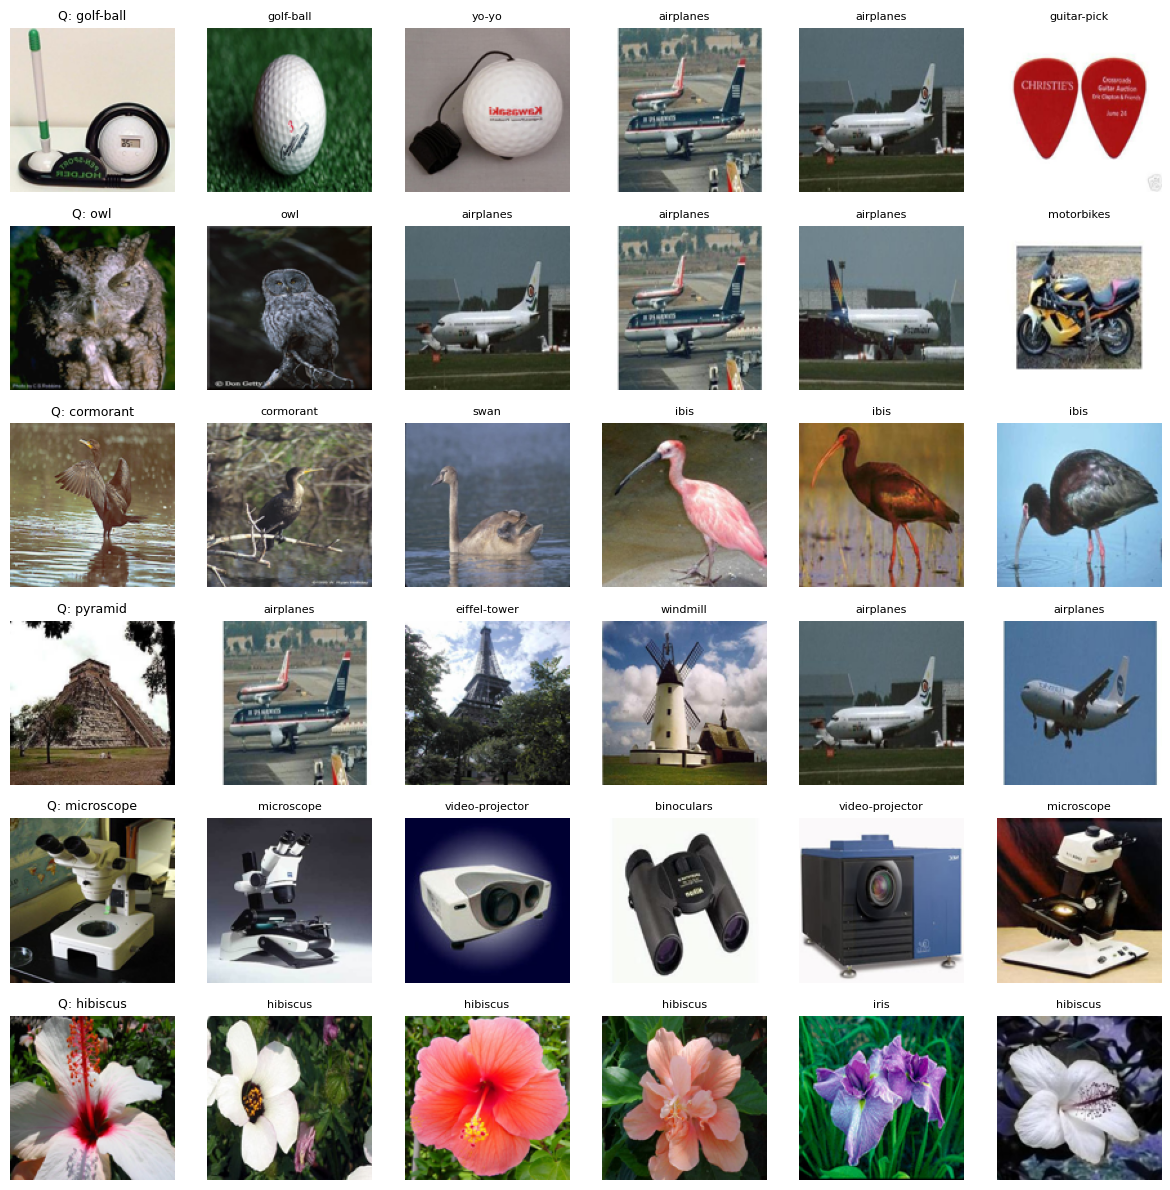

In [24]:
def make_nn_gallery(sample_indices, idxs, paths, labels, outpath: Path, n_neighbors=6, thumb_size=128):
    cols = n_neighbors
    rows = len(sample_indices)
    fig_w = cols * 2
    fig_h = rows * 2
    plt.figure(figsize=(fig_w, fig_h))
    for r, i in enumerate(sample_indices):
        neigh = idxs[i, :n_neighbors]
        for c, j in enumerate(neigh):
            ax = plt.subplot(rows, cols, r*cols + c + 1)
            img = Image.open(paths[j]).convert("RGB").resize((thumb_size, thumb_size))
            ax.imshow(img)
            ax.axis("off")
            if c == 0:
                ax.set_title(f"Q: {labels[j]}", fontsize=9)
            else:
                ax.set_title(labels[j], fontsize=8)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()

# pick a few diverse queries
rng = np.random.RandomState(SEED)
sample_indices = rng.choice(len(Xc), size=min(6, len(Xc)), replace=False)
make_nn_gallery(sample_indices, idxs, paths, y, OUT_DIR/"nn_gallery.png")


## 11) Discussion prompts (write your insights here)
Use the outputs/figures above to write answers such as:
- Which categories form tight clusters? Why?
- Which categories overlap? Are overlaps driven by color, shape, background?
- Which clusters contain multiple labels (ambiguity)?
- Which labels split into many clusters (high variability)?
- Are there outliers (DBSCAN label -1)? What do they look like?


In [25]:
# TODO: Write short bullet-point conclusions in Markdown cells above this one.
# This final cell is intentionally left as a placeholder to keep strict alternation.
pass
